In [1]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import time

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 8
BATCH_SIZE = 1
DEVICE = 'cuda:0' # default GPU device
GRAYSCALE = False

In [3]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet101(num_classes, grayscale):
    """Constructs a ResNet-101 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 23, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=grayscale)
    return model

In [4]:
torch.manual_seed(RANDOM_SEED)

model = resnet101(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)
model.load_state_dict(torch.load('resnet_epoch50.pth'))

<All keys matched successfully>

In [5]:
custom_transform = transforms.Compose([transforms.Resize((178, 178)),
                                       transforms.CenterCrop((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])
image_datasets=datasets.ImageFolder(r'./val', custom_transform)

loader = torch.utils.data.DataLoader(image_datasets, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [6]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [7]:
model.eval()
compute_accuracy(model, loader, DEVICE)

tensor(97.5000, device='cuda:0')

Let's first load in the names of all the items, attributes, and relations into Python lists.

In [8]:
with open('data/sem_items.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_relations.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_attributes.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])
        
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print('List of items:')
print(names_items)
print("List of relations:")
print(names_relations)
print("List of attributes:")
print(names_attributes)

List of items:
['Pine' 'Oak' 'Rose' 'Daisy' 'Robin' 'Canary' 'Sunfish' 'Salmon']
List of relations:
['ISA' 'Is' 'Can' 'Has']
List of attributes:
['Living thing' 'Plant' 'Animal' 'Tree' 'Flower' 'Bird' 'Fish' 'Pine'
 'Oak' 'Rose' 'Daisy' 'Robin' 'Canary' 'Sunfish' 'Salmon' 'Pretty' 'Big'
 'Living' 'Green' 'Red' 'Yellow' 'Grow' 'Move' 'Swim' 'Fly' 'Sing' 'Skin'
 'Roots' 'Leaves' 'Bark' 'Branch' 'Petals' 'Wings' 'Feathers' 'Gills'
 'Scales']


Next, let's load in the data matrix from a text file too. The matrix `D` has a row for each training pattern. It is split into a matrix of input patterns `input_pats` (item and relation) and their corresponding output patterns `output_pats` (attributes). The are `N` patterns total in the set.

For each input pattern, the first 8 elements indicate which item is being presented, and the next 4 indicate which relation is being queried. Each element of the output pattern corresponds to a different attribute. All patterns use 1-hot encoding.

In [9]:
D = np.loadtxt('data/sem_data.txt')
input_pats = D[:,:nobj+nrel]
input_pats = torch.tensor(input_pats,dtype=torch.float)
output_pats = D[:,nobj+nrel:]
output_pats = torch.tensor(output_pats,dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:8]])
print('Relation ',end='')
print(names_relations[input_v[8:]])
print('Attributes ',end='')
print(names_attributes[output_v])

Example input pattern:
[1 0 0 0 0 0 0 0 1 0 0 0]
Example output pattern:
[1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Which encodes...
Item ['Pine']
Relation ['ISA']
Attributes ['Living thing' 'Plant' 'Tree' 'Pine']


In [10]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        # TODO : YOUR CODE GOES HERE
#         self.linear11 = nn.Linear(nobj, rep_size)
#         self.linear12 = nn.Linear(rep_size, hidden_size)
        
#         self.linear22 = nn.Linear(nrel, hidden_size)
#         #self.linear23 = nn.Linear(hidden_size, nattributes)
#         self.linear23 = nn.Linear(2*hidden_size, nattributes)
        self.fwd1 = nn.Linear(nobj, rep_size)
        self.fwd2 = nn.Linear(nobj+nrel, hidden_size)
        self.fwd3 = nn.Linear(hidden_size, nattributes)


    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,nobj+nrel) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:nobj] # input to Item Layer [B x nobj Tensor]
        x_rel = x[:,nobj:] # input to Relation Layer [B x nrel Tensor]
        
#         rep = relu(self.linear11(x_item))#add random noise
        
#         hidden1 = self.linear12(rep)
        
#         hidden2 = self.linear22(x_rel)
        
#         #hidden = relu(hidden1 + hidden2)
        
#         hidden = relu(torch.cat((hidden1, hidden2), 1))
        
#         output = sigmoid(self.linear23(hidden))
        repitem = relu(self.fwd1(x_item))
        rep = torch.cat((repitem, x_rel), dim = 1)
        hidden = relu(self.fwd2(rep))
        output = torch.sigmoid(self.fwd3(hidden))

        
        
        return output, hidden, rep

We provide a completed function `train` for stochastic gradient descent. The network makes online (rather than batch) updates, adjusting its weights after the presentation of each input pattern.

In [11]:
inp_dict = {}
out_dict = {}
for idx in range(NUM_CLASSES):
    output_pats = D[idx*4:(idx+1)*4, nobj+nrel:]
    output_pats = torch.tensor(output_pats, dtype = torch.float)
    input_pats = D[idx*4:(idx+1)*4, :nobj+nrel]
    input_pats = torch.tensor(input_pats, dtype = torch.float)
    out_dict[str(idx)] = output_pats
    inp_dict[str(idx)] = input_pats

In [ ]:
#clmap = {'0':'5', '1':'3', '2':'1', '3':'0','4':'4','5':'2','6':'7','7':'6'}

In [13]:
def train(mynet,epoch_count,nepochs_additional=5000):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
#     inp_dict = {}
#     out_dict = {}
#     for idx in range(NUM_CLASSES):
#         output_pats = D[idx*5:(idx+1)*5, nobj+nrel:]
#         output_pats = torch.tensor(output_pats, dtype = torch.float)
#         input_pats = D[idx*5:(idx+1)*5, :nobj+nrel]
#         input_pats = torch.tensor(input_pats, dtype = torch.float)
#         out_dict[str(idx)] = output_pats
#         inp_dict[str(idx)] = input_pats
        
#     x_rel = D[:4, nobj:nobj+nrel]
#     x_rel = torch.tensor(x_rel, dtype = torch.float)
    model.eval()
    for e in range(nepochs_additional): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(nrel)
        for  i, (features, targets) in enumerate(loader):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            _, lbl = torch.max(probas, 1)
            lbl = lbl.item()
            #lbl = clmap[str(lbl)]
            output_pats = out_dict[str(lbl)]
            input_pats = inp_dict[str(lbl)]
            
            for p in perm:#range(perm): # iterate through input patterns in random order
                mynet.zero_grad() # reset gradient
                output, hidden, rep = mynet(input_pats[p,:].cuda()) # forward pass
                target = output_pats[p,:].cuda()
                loss = criterion(output, target) # compute loss
                loss.backward() # compute gradient 
                optimizer.step() # update network parameters
                error_epoch += loss.item()
        error_epoch = error_epoch / float(N)        
        print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
    return epoch_count + nepochs_additional

We provide some useful functions for extracting the activation pattern on the Representation Layer for each possible item. We provide two functions `plot_rep` and `plot_dendo` for visualizing these activation patterns.

In [12]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(nobj,nobj+nrel)
    for idx,name in enumerate(names_items):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean.cuda())
    return rep.cpu().detach().numpy()

def plot_rep(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1,nepochs_phase2,nepochs_phase3]
    nrows = nobj
    R = np.dstack((rep1,rep2,rep3))    
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    count = 1
    plt.figure(1,figsize=(4.2,8.4))
    for i in range(nrows):
        for d in range(R.shape[2]):
            plt.subplot(nrows, depth, count)
            rep = R[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names[i])
            if i==0:
                plt.title("epoch " + str(nepochs_list[d]))
            count += 1
    plt.show()

def plot_dendo(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1,nepochs_phase2,nepochs_phase3]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2],linked2[:,2],linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(7,12))
    plt.subplot(3,1,1)    
    dendrogram(linked1, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
    plt.ylabel('Euclidean distance')
    plt.subplot(3,1,2)
    plt.title("epoch " + str(nepochs_list[1]))
    dendrogram(linked2, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels=names, color_threshold=0)
    plt.ylim([0,mx])
    plt.show()

In [18]:

learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = Net(rep_size=8,hidden_size=15)
mynet.to(DEVICE)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent
#optimizer = torch.optim.Adam(mynet.parameters(), lr=learning_rate)

# nepochs_phase1 = 500
# nepochs_phase2 = 1000
# nepochs_phase3 = 2500
nepochs_phase1 = 20
nepochs_phase2 = 50
nepochs_phase3 = 100
epoch_count = 0
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase1)
rep1 = get_rep(mynet)
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase2-nepochs_phase1)
rep2 = get_rep(mynet)
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase3-nepochs_phase2)
rep3 = get_rep(mynet)


epoch 0 loss 2.323
epoch 1 loss 1.851
epoch 2 loss 1.234
epoch 3 loss 0.821
epoch 4 loss 0.726
epoch 5 loss 0.705
epoch 6 loss 0.696
epoch 7 loss 0.689
epoch 8 loss 0.683
epoch 9 loss 0.677
epoch 10 loss 0.669
epoch 11 loss 0.661
epoch 12 loss 0.651
epoch 13 loss 0.64
epoch 14 loss 0.628
epoch 15 loss 0.615
epoch 16 loss 0.602
epoch 17 loss 0.588
epoch 18 loss 0.575
epoch 19 loss 0.563
epoch 20 loss 0.552
epoch 21 loss 0.541
epoch 22 loss 0.531
epoch 23 loss 0.522
epoch 24 loss 0.514
epoch 25 loss 0.506
epoch 26 loss 0.499
epoch 27 loss 0.492
epoch 28 loss 0.486
epoch 29 loss 0.48
epoch 30 loss 0.475
epoch 31 loss 0.47
epoch 32 loss 0.466
epoch 33 loss 0.461
epoch 34 loss 0.457
epoch 35 loss 0.454
epoch 36 loss 0.45
epoch 37 loss 0.447
epoch 38 loss 0.444
epoch 39 loss 0.441
epoch 40 loss 0.438
epoch 41 loss 0.435
epoch 42 loss 0.433
epoch 43 loss 0.43
epoch 44 loss 0.427
epoch 45 loss 0.425
epoch 46 loss 0.422
epoch 47 loss 0.419
epoch 48 loss 0.417
epoch 49 loss 0.414
epoch 50 loss 0

In [31]:
#save reps
import pickle
with open('rep150.pkl', 'wb') as file:
    pickle.dump(rep1, file)
    

In [34]:
#load reps
with open('rep100.pkl', 'rb') as file:
    repp = pickle.load(file)

In [32]:
#save mynet
torch.save(mynet.state_dict(), 'mynet_epoch150.pth')

Finally, let's visualize the Representation Layer at the different stages of learning.

comparison plot


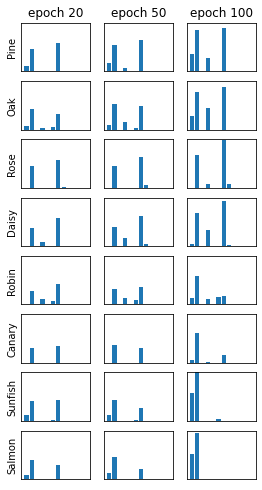

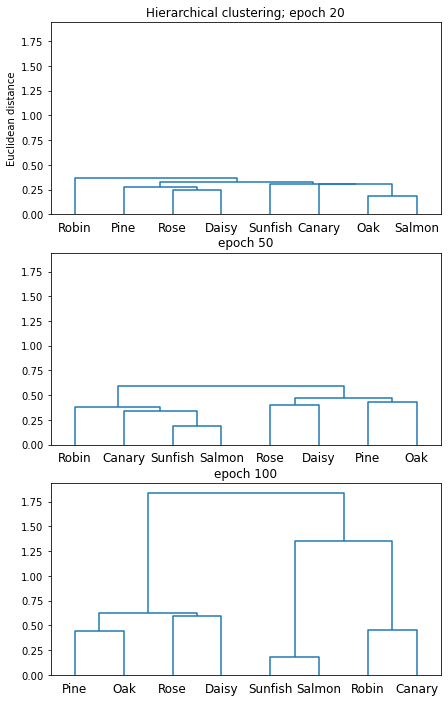

In [19]:
print('comparison plot')
plot_rep(rep1,rep2,rep3,names_items)
plot_dendo(rep1,rep2,rep3,names_items)

In [30]:
#load mynet
# loading checkpoints
mynet = Net(rep_size=8,hidden_size=15)
mynet.load_state_dict(torch.load('mynet_epoch100.pth'))
mynet.to(DEVICE)
learning_rate = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate)


nepochs_phase1 = 50
epoch_count = 0
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase1)
rep1 = get_rep(mynet)

epoch 0 loss 0.21
epoch 1 loss 0.208
epoch 2 loss 0.205
epoch 3 loss 0.203
epoch 4 loss 0.2
epoch 5 loss 0.198
epoch 6 loss 0.194
epoch 7 loss 0.193
epoch 8 loss 0.191
epoch 9 loss 0.189
epoch 10 loss 0.186
epoch 11 loss 0.183
epoch 12 loss 0.181
epoch 13 loss 0.178
epoch 14 loss 0.174
epoch 15 loss 0.173
epoch 16 loss 0.17
epoch 17 loss 0.168
epoch 18 loss 0.164
epoch 19 loss 0.162
epoch 20 loss 0.159
epoch 21 loss 0.156
epoch 22 loss 0.153
epoch 23 loss 0.151
epoch 24 loss 0.149
epoch 25 loss 0.145
epoch 26 loss 0.143
epoch 27 loss 0.14
epoch 28 loss 0.138
epoch 29 loss 0.135
epoch 30 loss 0.133
epoch 31 loss 0.131
epoch 32 loss 0.129
epoch 33 loss 0.126
epoch 34 loss 0.125
epoch 35 loss 0.123
epoch 36 loss 0.121
epoch 37 loss 0.119
epoch 38 loss 0.118
epoch 39 loss 0.116
epoch 40 loss 0.115
epoch 41 loss 0.113
epoch 42 loss 0.112
epoch 43 loss 0.109
epoch 44 loss 0.11
epoch 45 loss 0.108
epoch 46 loss 0.107
epoch 47 loss 0.106
epoch 48 loss 0.105
epoch 49 loss 0.104
